In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/supply-chain-analysis/supply_chain_data.csv


In [2]:
!pip install imbalanced-learn==0.9.1
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                           classification_report, roc_auc_score, 
                           precision_recall_curve, average_precision_score)
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# Set visualization styles
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
pd.set_option('display.max_columns', None)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


# Data Loading and Initial Inspection


In [3]:
# Load the dataset
df = pd.read_csv("/kaggle/input/supply-chain-analysis/supply_chain_data.csv")

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

# Check data types and missing values
print("\nData types and missing values:")
display(df.info())

# Check for duplicates
print(f"\nNumber of duplicates: {df.duplicated().sum()}")

Dataset shape: (100, 24)

First 5 rows:


,Product type,SKU,Price,Availability,Number of products sold,Revenue generated,Customer demographics,Stock levels,Lead times,Order quantities,Shipping times,Shipping carriers,Shipping costs,Supplier name,Location,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs
0,haircare,SKU0,69.808006,55,802,8661.996792,Non-binary,58,7,96,4,Carrier B,2.956572,Supplier 3,Mumbai,29,215,29,46.279879,Pending,0.226410,Road,Route B,187.752075
1,skincare,SKU1,14.843523,95,736,7460.900065,Female,53,30,37,2,Carrier A,9.716575,Supplier 3,Mumbai,23,517,30,33.616769,Pending,4.854068,Road,Route B,503.065579
2,haircare,SKU2,11.319683,34,8,9577.749626,Unknown,1,10,88,2,Carrier B,8.054479,Supplier 1,Mumbai,12,971,27,30.688019,Pending,4.580593,Air,Route C,141.920282
3,skincare,SKU3,61.163343,68,83,7766.836426,Non-binary,23,13,59,6,Carrier C,1.729569,Supplier 5,Kolkata,24,937,18,35.624741,Fail,4.746649,Rail,Route A,254.776159
4,skincare,SKU4,4.805496,26,871,2686.505152,Non-binary,5,3,56,8,Carrier A,3.890548,Supplier 1,Delhi,5,414,3,92.065161,Fail,3.145580,Air,Route A,923.440632



Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product type             100 non-null    object 
 1   SKU                      100 non-null    object 
 2   Price                    100 non-null    float64
 3   Availability             100 non-null    int64  
 4   Number of products sold  100 non-null    int64  
 5   Revenue generated        100 non-null    float64
 6   Customer demographics    100 non-null    object 
 7   Stock levels             100 non-null    int64  
 8   Lead times               100 non-null    int64  
 9   Order quantities         100 non-null    int64  
 10  Shipping times           100 non-null    int64  
 11  Shipping carriers        100 non-null    object 
 12  Shipping costs           100 non-null    float64
 13  Supplier name            100 non-null    object 


None


Number of duplicates: 0


# Comprehensive EDA

## 1. Product Analysis

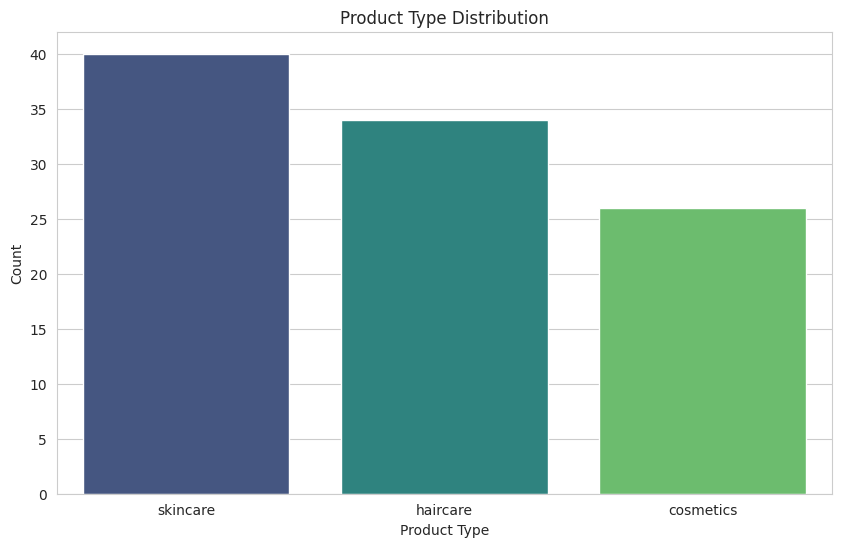

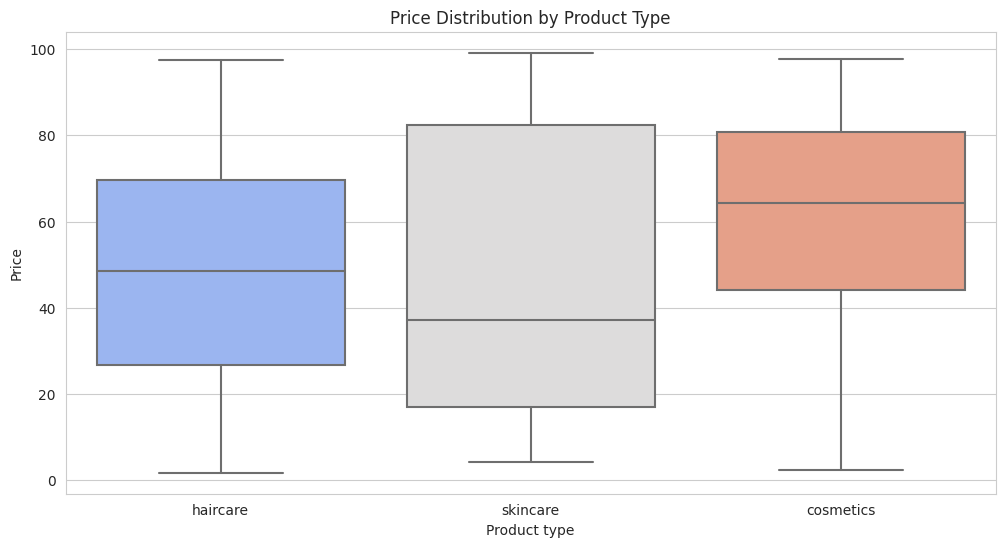

In [4]:
# Product type distribution
plt.figure(figsize=(10, 6))
product_counts = df['Product type'].value_counts()
sns.barplot(x=product_counts.index, y=product_counts.values, palette="viridis")
plt.title('Product Type Distribution')
plt.xlabel('Product Type')
plt.ylabel('Count')
plt.show()

# Price distribution by product type
plt.figure(figsize=(12, 6))
sns.boxplot(x='Product type', y='Price', data=df, palette="coolwarm")
plt.title('Price Distribution by Product Type')
plt.show()

# Revenue vs Products Sold
fig = px.scatter(df, x='Number of products sold', y='Revenue generated', 
                 color='Product type', size='Price',
                 title='Revenue vs Products Sold by Product Type')
fig.show()

# 2. Location and Supplier Analysis


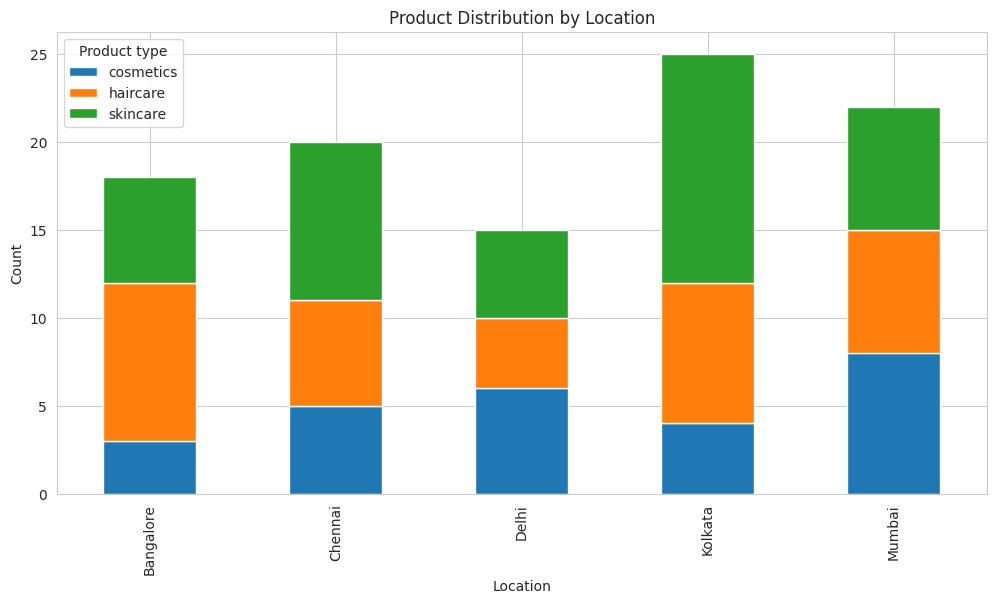

In [5]:
# Location-wise product distribution
location_product = df.groupby(['Location', 'Product type']).size().unstack()
location_product.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Product Distribution by Location')
plt.ylabel('Count')
plt.show()

# Supplier performance metrics
supplier_metrics = df.groupby('Supplier name').agg({
    'Lead times': 'mean',
    'Manufacturing costs': 'mean',
    'Defect rates': 'mean'
}).reset_index()

fig = px.bar(supplier_metrics, x='Supplier name', y=['Lead times', 'Manufacturing costs', 'Defect rates'],
             title='Supplier Performance Metrics', barmode='group')
fig.show()

# 3. Transportation and Logistics Analysis


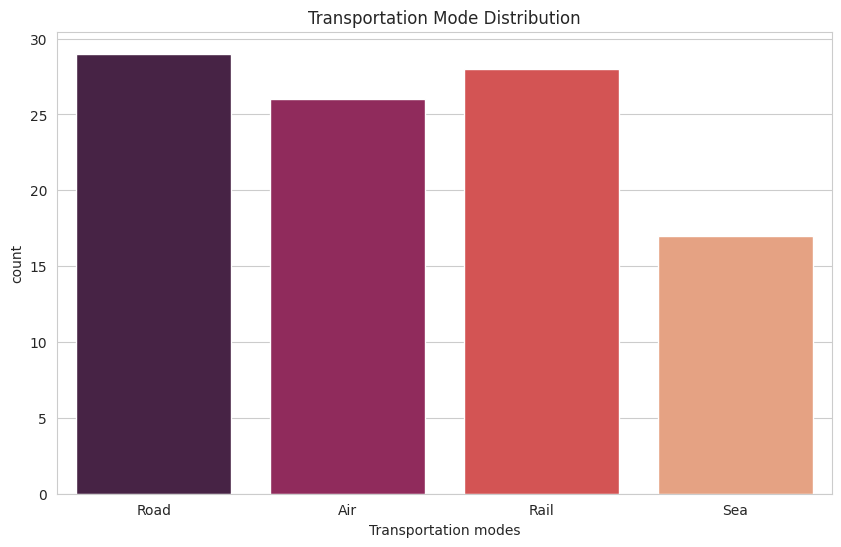

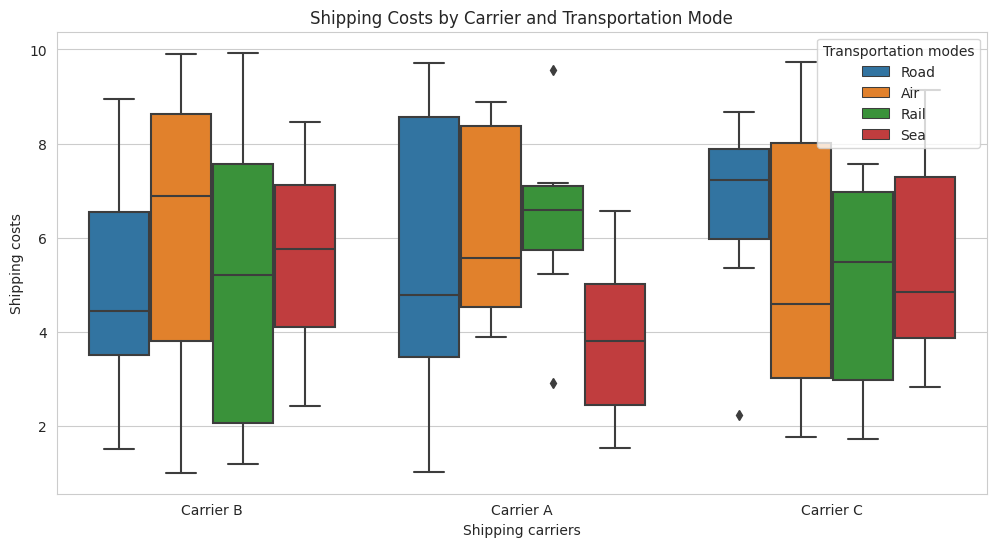

In [6]:
# Transportation mode analysis
plt.figure(figsize=(10, 6))
sns.countplot(x='Transportation modes', data=df, palette="rocket")
plt.title('Transportation Mode Distribution')
plt.show()

# Shipping costs by carrier
plt.figure(figsize=(12, 6))
sns.boxplot(x='Shipping carriers', y='Shipping costs', hue='Transportation modes', data=df)
plt.title('Shipping Costs by Carrier and Transportation Mode')
plt.show()

# Lead time vs Manufacturing costs
fig = px.scatter(df, x='Lead times', y='Manufacturing costs', 
                 color='Product type', size='Production volumes',
                 title='Lead Time vs Manufacturing Costs')
fig.show()

# 4. Quality Control Analysis


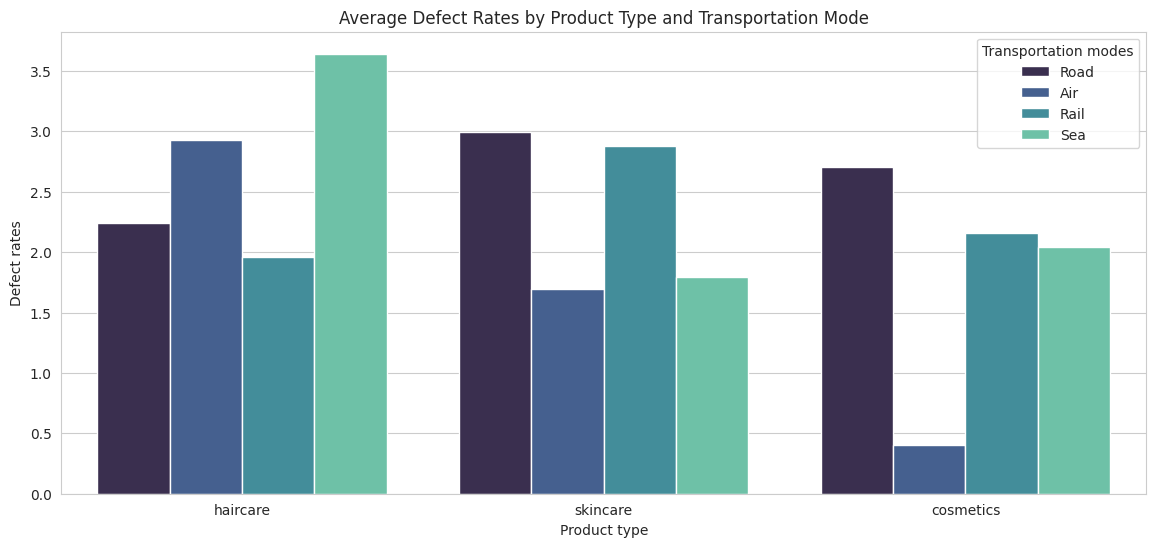

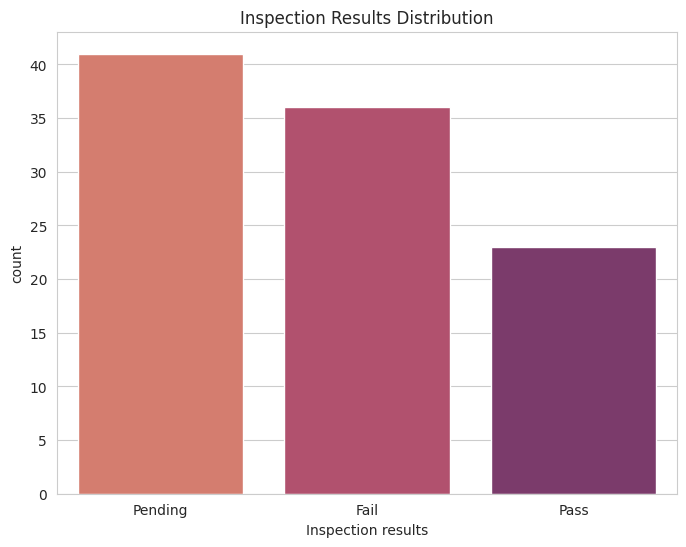

In [7]:
# Defect rates by product type and transportation mode
plt.figure(figsize=(14, 6))
sns.barplot(x='Product type', y='Defect rates', hue='Transportation modes', 
            data=df, estimator=np.mean, ci=None, palette="mako")
plt.title('Average Defect Rates by Product Type and Transportation Mode')
plt.show()

# Inspection results
plt.figure(figsize=(8, 6))
sns.countplot(x='Inspection results', data=df, palette="flare")
plt.title('Inspection Results Distribution')
plt.show()

# Defect rates vs Manufacturing costs
fig = px.scatter(df, x='Defect rates', y='Manufacturing costs', 
                 color='Inspection results', trendline="ols",
                 title='Defect Rates vs Manufacturing Costs')
fig.show()

# Data Preprocessing for Predictive Modeling


In [8]:
# Create a target variable - High Defect Rate (1 if defect rate > median, else 0)
median_defect = df['Defect rates'].median()
df['High_Defect'] = (df['Defect rates'] > median_defect).astype(int)

# Select features and target
features = ['Price', 'Availability', 'Number of products sold', 'Revenue generated',
           'Stock levels', 'Lead times', 'Order quantities', 'Shipping times',
           'Shipping costs', 'Lead time', 'Production volumes',
           'Manufacturing lead time', 'Manufacturing costs']
target = 'High_Defect'

X = df[features]
y = df[target]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Predictive Modeling

## 1. Logistic Regression (Baseline)

Logistic Regression Performance:
Accuracy: 0.6333
ROC AUC: 0.6578

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.73      0.67        15
           1       0.67      0.53      0.59        15

    accuracy                           0.63        30
   macro avg       0.64      0.63      0.63        30
weighted avg       0.64      0.63      0.63        30



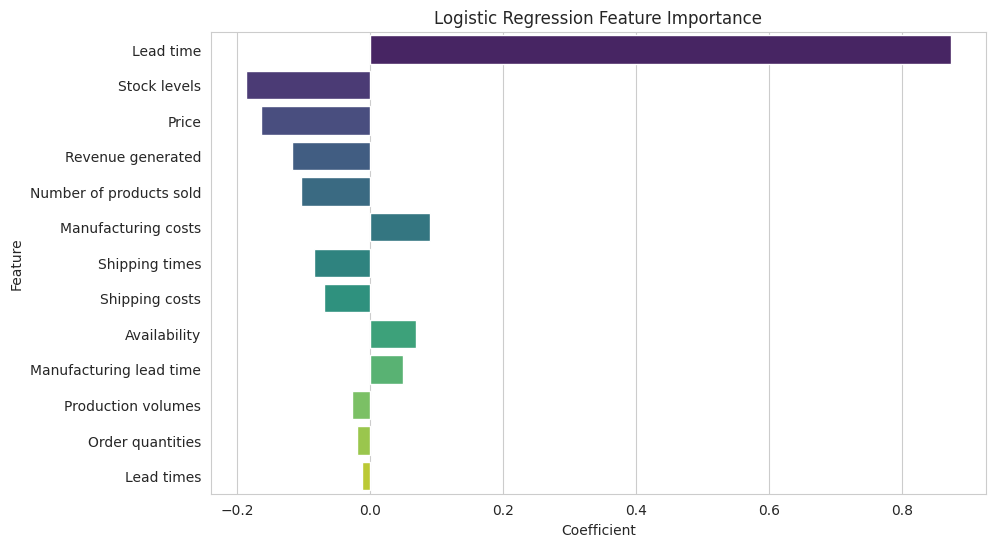

In [9]:
# Initialize and train logistic regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

# Evaluate model
print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# Feature importance
lr_coef = pd.DataFrame({'Feature': features, 'Coefficient': lr.coef_[0]})
lr_coef = lr_coef.sort_values('Coefficient', key=abs, ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=lr_coef, palette="viridis")
plt.title('Logistic Regression Feature Importance')
plt.show()

# 2. Random Forest Classifier


Random Forest Performance:
Accuracy: 0.5333
ROC AUC: 0.4844

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.60      0.56        15
           1       0.54      0.47      0.50        15

    accuracy                           0.53        30
   macro avg       0.53      0.53      0.53        30
weighted avg       0.53      0.53      0.53        30



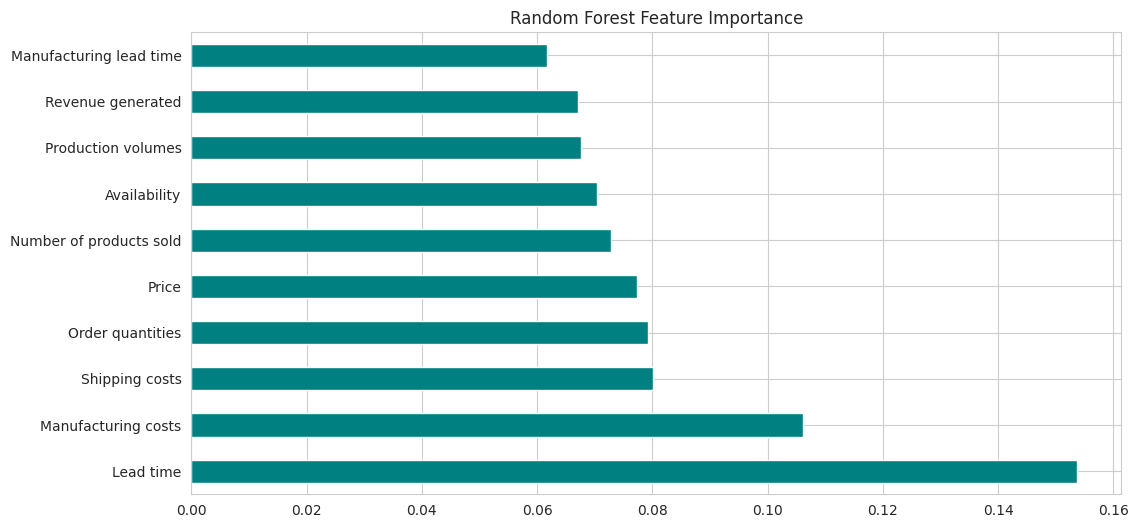

In [10]:
# Initialize and train random forest
rf = RandomForestClassifier(n_estimators=200, max_depth=10, 
                          random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]

# Evaluate model
print("Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Feature importance
rf_feat_importances = pd.Series(rf.feature_importances_, index=features)
rf_feat_importances.nlargest(10).plot(kind='barh', color='teal')
plt.title('Random Forest Feature Importance')
plt.show()

# 3. LightGBM Classifier


[LightGBM] [Info] Number of positive: 35, number of negative: 35
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 287
[LightGBM] [Info] Number of data points in the train set: 70, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

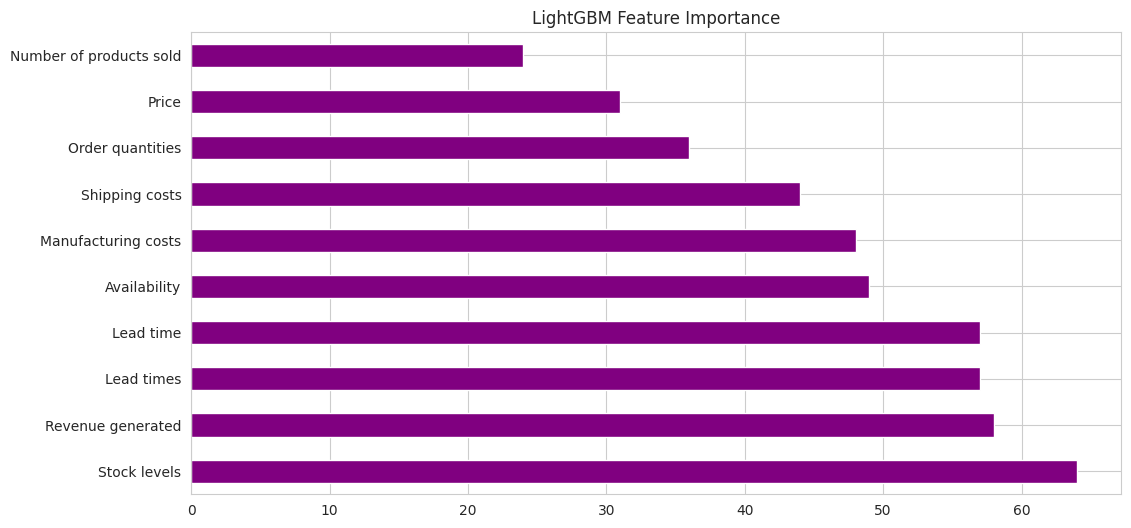

In [11]:
# Initialize and train LightGBM
lgbm = LGBMClassifier(n_estimators=300, learning_rate=0.05, 
                     max_depth=7, random_state=42, n_jobs=-1)
lgbm.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lgbm = lgbm.predict(X_test_scaled)
y_prob_lgbm = lgbm.predict_proba(X_test_scaled)[:, 1]

# Evaluate model
print("LightGBM Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgbm):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_lgbm):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgbm))

# Feature importance
lgbm_feat_importances = pd.Series(lgbm.feature_importances_, index=features)
lgbm_feat_importances.nlargest(10).plot(kind='barh', color='purple')
plt.title('LightGBM Feature Importance')
plt.show()

# 4. CatBoost Classifier


0:	learn: 0.6728401	total: 51.9ms	remaining: 25.9s
100:	learn: 0.0874859	total: 125ms	remaining: 494ms
200:	learn: 0.0275339	total: 197ms	remaining: 294ms
300:	learn: 0.0153465	total: 271ms	remaining: 179ms
400:	learn: 0.0105847	total: 344ms	remaining: 85ms
499:	learn: 0.0078906	total: 416ms	remaining: 0us
CatBoost Performance:
Accuracy: 0.4000
ROC AUC: 0.4400

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.27      0.31        15
           1       0.42      0.53      0.47        15

    accuracy                           0.40        30
   macro avg       0.39      0.40      0.39        30
weighted avg       0.39      0.40      0.39        30



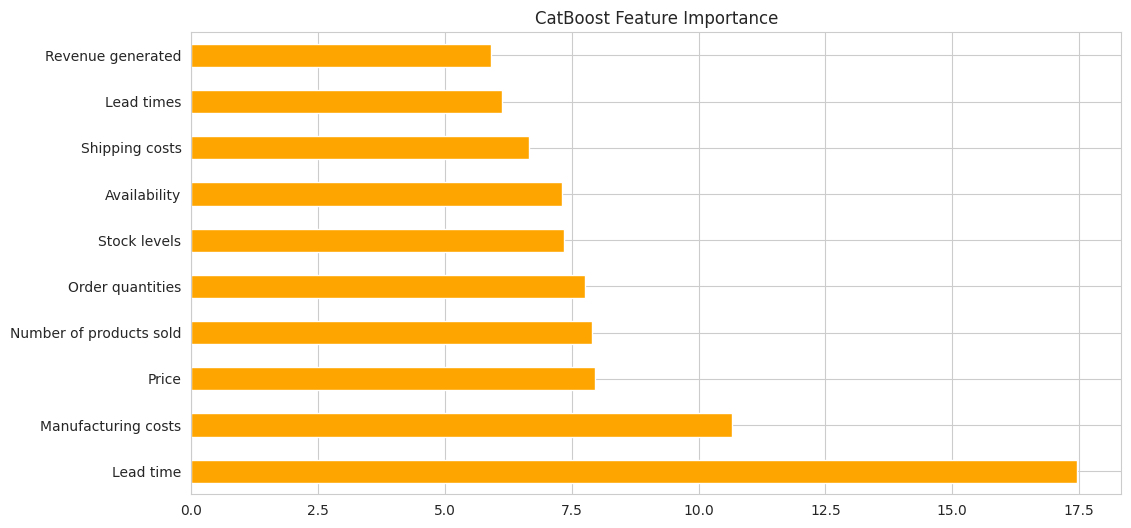

In [12]:
# Initialize and train CatBoost
catboost = CatBoostClassifier(iterations=500, learning_rate=0.05, 
                            depth=6, random_seed=42, verbose=100)
catboost.fit(X_train_scaled, y_train)

# Make predictions
y_pred_cat = catboost.predict(X_test_scaled)
y_prob_cat = catboost.predict_proba(X_test_scaled)[:, 1]

# Evaluate model
print("CatBoost Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_cat):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_cat):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_cat))

# Feature importance
catboost_feat_importances = pd.Series(catboost.feature_importances_, index=features)
catboost_feat_importances.nlargest(10).plot(kind='barh', color='orange')
plt.title('CatBoost Feature Importance')
plt.show()

# Model Comparison and Selection



Model Comparison:


,Model,Accuracy,ROC AUC
0,Logistic Regression,0.633333,0.657778
2,LightGBM,0.433333,0.573333
1,Random Forest,0.533333,0.484444
3,CatBoost,0.400000,0.440000


<Figure size 1200x600 with 0 Axes>

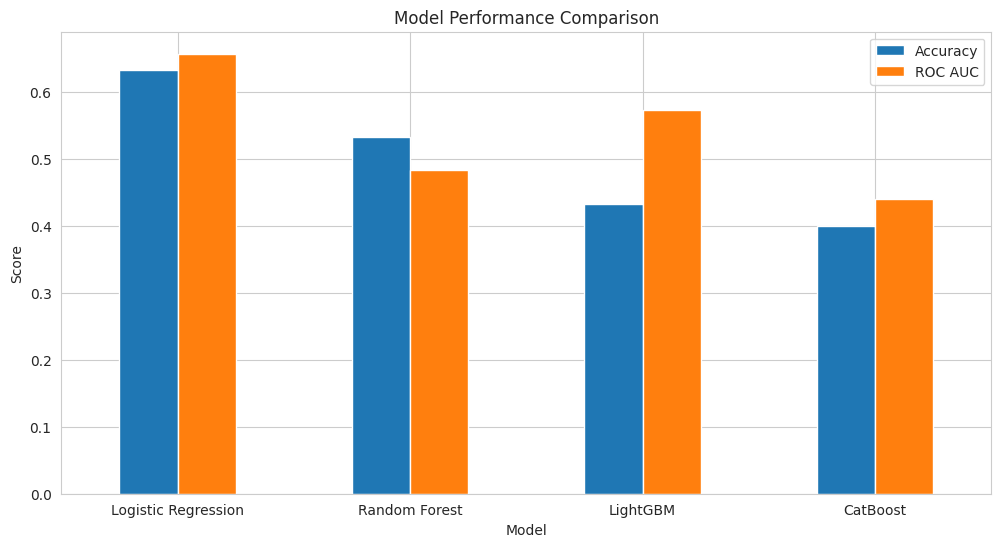

In [13]:
# Create a comparison dataframe
models = ['Logistic Regression', 'Random Forest', 'LightGBM', 'CatBoost']
accuracy = [accuracy_score(y_test, y_pred_lr),
           accuracy_score(y_test, y_pred_rf),
           accuracy_score(y_test, y_pred_lgbm),
           accuracy_score(y_test, y_pred_cat)]
roc_auc = [roc_auc_score(y_test, y_prob_lr),
          roc_auc_score(y_test, y_prob_rf),
          roc_auc_score(y_test, y_prob_lgbm),
          roc_auc_score(y_test, y_prob_cat)]

results = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'ROC AUC': roc_auc
})

# Display results
print("\nModel Comparison:")
display(results.sort_values(by='ROC AUC', ascending=False))

# Visual comparison
plt.figure(figsize=(12, 6))
results.set_index('Model').plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()

# Advanced Techniques

## 1. Hyperparameter Tuning for Best Model (CatBoost)

In [14]:
# Define parameter grid
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [300, 500, 700]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=catboost, 
                          param_grid=param_grid, 
                          cv=3, 
                          scoring='roc_auc',
                          n_jobs=-1,
                          verbose=1)

# Perform grid search
grid_search.fit(X_train_scaled, y_train)

# Get best parameters
print("\nBest parameters found:")
print(grid_search.best_params_)

# Evaluate best model
best_catboost = grid_search.best_estimator_
y_pred_best = best_catboost.predict(X_test_scaled)
y_prob_best = best_catboost.predict_proba(X_test_scaled)[:, 1]

print("\nTuned CatBoost Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_best):.4f}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
0:	learn: 0.6449420	total: 2.75ms	remaining: 1.92s
100:	learn: 0.0293203	total: 152ms	remaining: 901ms
200:	learn: 0.0127424	total: 303ms	remaining: 753ms
300:	learn: 0.0081240	total: 452ms	remaining: 599ms
400:	learn: 0.0061491	total: 616ms	remaining: 459ms
500:	learn: 0.0047501	total: 770ms	remaining: 306ms
600:	learn: 0.0039485	total: 923ms	remaining: 152ms
699:	learn: 0.0033816	total: 1.07s	remaining: 0us

Best parameters found:
{'depth': 8, 'iterations': 700, 'learning_rate': 0.1}

Tuned CatBoost Performance:
Accuracy: 0.4667
ROC AUC: 0.4667


# 2. Ensemble of Best Models


In [15]:
# Create voting classifier with top 3 models
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('lgbm', lgbm),
        ('catboost', best_catboost)
    ],
    voting='soft'
)

# Train ensemble
voting_clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_ens = voting_clf.predict(X_test_scaled)
y_prob_ens = voting_clf.predict_proba(X_test_scaled)[:, 1]

# Evaluate ensemble
print("\nEnsemble Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ens):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_ens):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ens))

[LightGBM] [Info] Number of positive: 35, number of negative: 35
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 287
[LightGBM] [Info] Number of data points in the train set: 70, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [16]:
# Save the best model for deployment
import joblib
joblib.dump(best_catboost, 'supply_chain_defect_predictor.pkl')

['supply_chain_defect_predictor.pkl']